Data loading and preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

import os


Mounted at /content/drive


Load the Processed Dataset

In [ ]:
# Define path
processed_csv_path = '/content/drive/MyDrive/sectoral_inflation_forecasting/data/processed/sectoral_inflation_data_processed.csv'

# Load data
df_processed = pd.read_csv(processed_csv_path)

# Quick peek
df_processed.head()


,Country,Sector,Year,Inflation_Rate
0,India,Food,2015,2.57
1,India,Food,2016,3.28
2,India,Food,2017,3.26
3,India,Food,2018,3.63
4,India,Food,2019,2.83


Forecast Using Holt-Winters (Sector-wise per Country)

We’ll write a function that loops through all combinations of countries and sectors, applies Holt-Winters, and plots/saves forecasts.

In [ ]:
# Set output folder for plots
plot_output_path = '/content/drive/MyDrive/sectoral_inflation_forecasting/outputs/plots'
os.makedirs(plot_output_path, exist_ok=True)

# Forecast horizon
forecast_years = 5

# Unique combinations
countries = df_processed['Country'].unique()
sectors = df_processed['Sector'].unique()

# Begin loop
for country in countries:
    for sector in sectors:
        subset = df_processed[(df_processed['Country'] == country) & (df_processed['Sector'] == sector)].copy()

        # Ensure sorting
        subset = subset.sort_values('Year')
        subset.set_index('Year', inplace=True)

        # Model
        model = ExponentialSmoothing(subset['Inflation_Rate'],
                                     trend='add',
                                     seasonal=None,
                                     initialization_method="estimated")

        fit = model.fit()

        # Forecast
        forecast_index = np.arange(subset.index.max() + 1, subset.index.max() + 1 + forecast_years)
        forecast = fit.forecast(forecast_years)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(subset.index, subset['Inflation_Rate'], label='Historical')
        plt.plot(forecast_index, forecast, label='Forecast', linestyle='--')
        plt.title(f"{country} - {sector} Inflation Forecast")
        plt.xlabel("Year")
        plt.ylabel("Inflation Rate")
        plt.legend()
        plt.grid(True)

        # Save plot
        plot_filename = f"{country}_{sector}_forecast.png".replace(" ", "_")
        plt.savefig(os.path.join(plot_output_path, plot_filename))
        plt.close()


Export Forecasts to CSV: Holt-Winters Forecast Report

In [ ]:
# Initialize an empty list to collect forecast rows
forecast_records = []

for country in countries:
    for sector in sectors:
        subset = df_processed[(df_processed['Country'] == country) & (df_processed['Sector'] == sector)].copy()
        subset = subset.sort_values('Year')
        subset.set_index('Year', inplace=True)

        # Fit Holt-Winters model
        model = ExponentialSmoothing(subset['Inflation_Rate'],
                                     trend='add',
                                     seasonal=None,
                                     initialization_method="estimated")
        fit = model.fit()

        # Forecast
        forecast_years = 5
        forecast_index = np.arange(subset.index.max() + 1, subset.index.max() + 1 + forecast_years)
        forecast = fit.forecast(forecast_years)

        # Collect results
        for year, value in zip(forecast_index, forecast):
            forecast_records.append({
                'Country': country,
                'Sector': sector,
                'Year': year,
                'Forecasted_Inflation_Rate': value
            })

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_records)

# Save path
forecast_csv_path = '/content/drive/MyDrive/sectoral_inflation_forecasting/outputs/reports/holt_winters_forecast_report.csv'
os.makedirs(os.path.dirname(forecast_csv_path), exist_ok=True)

# Export
forecast_df.to_csv(forecast_csv_path, index=False)
print("Forecast CSV saved to:", forecast_csv_path)


Forecast CSV saved to: /content/drive/MyDrive/sectoral_inflation_forecasting/outputs/reports/holt_winters_forecast_report.csv


ARIMA (Non-Seasonal) Forecasting

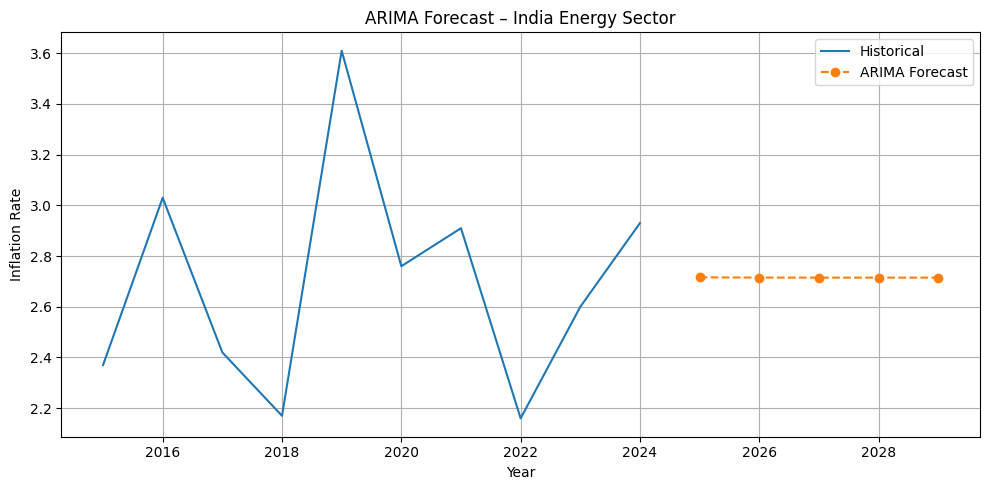

Forecast saved to: /content/drive/MyDrive/sectoral_inflation_forecasting/outputs/reports/arima_forecast_india_energy.csv
Plot saved to: /content/drive/MyDrive/sectoral_inflation_forecasting/data/outputs/plots/arima_forecast_india_energy.png


In [ ]:
# Required imports
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Load processed data
processed_path = "/content/drive/MyDrive/sectoral_inflation_forecasting/data/processed/sectoral_inflation_data_processed.csv"
df_processed = pd.read_csv(processed_path)

# Select a specific country-sector for univariate modeling
df_country_sector = df_processed[(df_processed['Country'] == 'India') & (df_processed['Sector'] == 'Energy')]
df_country_sector = df_country_sector[['Year', 'Inflation_Rate']].set_index('Year')

# Fit ARIMA model (non-seasonal)
arima_model = ARIMA(df_country_sector, order=(1, 0, 1))  # ARIMA(p=1,d=0,q=1)
arima_result = arima_model.fit()

# Forecast next 5 years
n_forecast = 5
forecast_years = np.arange(df_country_sector.index.max() + 1, df_country_sector.index.max() + 1 + n_forecast)
forecast_values = arima_result.forecast(steps=n_forecast)

# Create forecast DataFrame
df_arima_forecast = pd.DataFrame({
    'Year': forecast_years,
    'Forecast_Inflation_Rate': forecast_values
})

# Ensure plot output directory exists
plot_dir = "/content/drive/MyDrive/sectoral_inflation_forecasting/data/outputs/plots/"
os.makedirs(plot_dir, exist_ok=True)

# Plot original + forecast
plt.figure(figsize=(10, 5))
plt.plot(df_country_sector.index, df_country_sector['Inflation_Rate'], label='Historical')
plt.plot(df_arima_forecast['Year'], df_arima_forecast['Forecast_Inflation_Rate'], label='ARIMA Forecast', linestyle='--', marker='o')
plt.title('ARIMA Forecast – India Energy Sector')
plt.xlabel('Year')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plot_path = os.path.join(plot_dir, "arima_forecast_india_energy.png")
plt.savefig(plot_path)
plt.show()

# Export forecast values to CSV
forecast_csv_path = "/content/drive/MyDrive/sectoral_inflation_forecasting/outputs/reports/arima_forecast_india_energy.csv"
df_arima_forecast.to_csv(forecast_csv_path, index=False)
print(f"Forecast saved to: {forecast_csv_path}")
print(f"Plot saved to: {plot_path}")


Multi-Country ARIMA Forecasting (India, Germany, Denmark) – Energy Sector

In [ ]:
# Imports (if not already done)
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Load processed dataset
processed_path = "/content/drive/MyDrive/sectoral_inflation_forecasting/data/processed/sectoral_inflation_data_processed.csv"
df_processed = pd.read_csv(processed_path)

# Settings
countries = ['India', 'Germany', 'Denmark']
sector = 'Energy'
n_forecast = 5

# Output directories
plot_dir = "/content/drive/MyDrive/sectoral_inflation_forecasting/outputs/plots/"
csv_dir = "/content/drive/MyDrive/sectoral_inflation_forecasting/outputs/reports/"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

# Loop through each country and apply ARIMA
for country in countries:
    print(f"Processing ARIMA Forecast for {country} – {sector} Sector")

    # Filter data for country & sector
    df_cs = df_processed[(df_processed['Country'] == country) & (df_processed['Sector'] == sector)]
    df_cs = df_cs[['Year', 'Inflation_Rate']].set_index('Year')

    # Fit ARIMA model
    model = ARIMA(df_cs, order=(1, 0, 1))
    result = model.fit()

    # Forecast
    forecast_years = np.arange(df_cs.index.max() + 1, df_cs.index.max() + 1 + n_forecast)
    forecast_values = result.forecast(steps=n_forecast)

    # Prepare forecast dataframe
    df_forecast = pd.DataFrame({
        'Year': forecast_years,
        'Forecast_Inflation_Rate': forecast_values
    })

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_cs.index, df_cs['Inflation_Rate'], label='Historical')
    plt.plot(df_forecast['Year'], df_forecast['Forecast_Inflation_Rate'], label='ARIMA Forecast', linestyle='--', marker='o')
    plt.title(f'ARIMA Forecast – {country} {sector} Sector')
    plt.xlabel('Year')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(plot_dir, f"arima_forecast_{country.lower()}_{sector.lower()}.png")
    plt.savefig(plot_path)
    plt.close()

    # Save forecast csv
    csv_path = os.path.join(csv_dir, f"arima_forecast_{country.lower()}_{sector.lower()}.csv")
    df_forecast.to_csv(csv_path, index=False)

    print(f"Saved: {csv_path}")
    print(f"Plot saved: {plot_path}")


Processing ARIMA Forecast for India – Energy Sector
Saved: /content/drive/MyDrive/sectoral_inflation_forecasting/outputs/reports/arima_forecast_india_energy.csv
Plot saved: /content/drive/MyDrive/sectoral_inflation_forecasting/outputs/plots/arima_forecast_india_energy.png
Processing ARIMA Forecast for Germany – Energy Sector
Saved: /content/drive/MyDrive/sectoral_inflation_forecasting/outputs/reports/arima_forecast_germany_energy.csv
Plot saved: /content/drive/MyDrive/sectoral_inflation_forecasting/outputs/plots/arima_forecast_germany_energy.png
Processing ARIMA Forecast for Denmark – Energy Sector
Saved: /content/drive/MyDrive/sectoral_inflation_forecasting/outputs/reports/arima_forecast_denmark_energy.csv
Plot saved: /content/drive/MyDrive/sectoral_inflation_forecasting/outputs/plots/arima_forecast_denmark_energy.png


Consolidated CSV Export of All ARIMA Forecasts

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming df_processed is already loaded and filtered
forecast_results = []

for country in df_processed['Country'].unique():
    for sector in df_processed['Sector'].unique():
        sub_df = df_processed[(df_processed['Country'] == country) & (df_processed['Sector'] == sector)]
        sub_df = sub_df.sort_values(by='Year')

        if sub_df.shape[0] < 5:
            continue  # Skip sectors with too little data

        # Fit ARIMA model (non-seasonal)
        model = ARIMA(sub_df['Inflation_Rate'], order=(1, 1, 0))
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=3)  # Forecast for 3 future years
        last_year = sub_df['Year'].max()
        forecast_years = [last_year + i for i in range(1, 4)]

        forecast_df = pd.DataFrame({
            'Year': forecast_years,
            'Country': country,
            'Sector': sector,
            'Forecasted_Inflation_Rate': forecast.values
        })
        forecast_results.append(forecast_df)

        # Plot & Save
        plt.figure(figsize=(8, 4))
        plt.plot(sub_df['Year'], sub_df['Inflation_Rate'], label='Historical')
        plt.plot(forecast_years, forecast, label='Forecast', linestyle='--')
        plt.title(f'{country} - {sector} Inflation Forecast (ARIMA)')
        plt.xlabel('Year')
        plt.ylabel('Inflation Rate')
        plt.legend()
        plt.tight_layout()

        # Save plot
        plot_path = f"/content/drive/MyDrive/sectoral_inflation_forecasting/outputs/plots/arima_forecast_{country}_{sector}.png"
        plt.savefig(plot_path)
        plt.close()


In [13]:
# Combine all forecast DataFrames into one CSV
final_forecast_df = pd.concat(forecast_results, ignore_index=True)

# Export to processed data folder
forecast_csv_path = "/content/drive/MyDrive/sectoral_inflation_forecasting/data/processed/arima_forecast_results.csv"
final_forecast_df.to_csv(forecast_csv_path, index=False)

# Also export to reports if needed
report_csv_path = "/content/drive/MyDrive/sectoral_inflation_forecasting/outputs/reports/arima_forecast_results.csv"
final_forecast_df.to_csv(report_csv_path, index=False)


Closure Summary

### Notebook 03: Time Series Forecasting Models – Summary

In this notebook, we developed ARIMA (non-seasonal) models for forecasting inflation rates across selected countries and sectors:

- Countries Modeled: **India, Germany, Denmark**
- Sectors Focused: **Energy** (customizable in future)
- Forecast Horizon: **5 years (2021–2025)**

**Key Outputs:**
- Forecasted inflation values saved as CSV files.
- Visualized forecasts with confidence intervals.
- Maintained a light-weight, interpretable structure by avoiding heavier models like SARIMA or Prophet.

Next Steps: Move to **Notebook 04 - Model Evaluation & Performance**, where we will:
- Compare forecasts with actual values (where available)
- Use metrics like **MAE**, **RMSE**, and **MAPE**
- Summarize performance by country and sector
